In [1]:
path_to_project = '/content/drive/MyDrive/Deep_Learning-Go_Project/Game' # Update with your path

# Configuring colab environment for the project


## Versioning libraries
Source code was developped under old version of tensorflow and is not actively maintained.  
Therefore, you must execute the cells below.

In [ ]:
!pip install tensorrt-bindings==8.6.1
!pip install --extra-index-url https://pypi.nvidia.com tensorrt-libs
!pip install tensorflow[and-cuda]==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.8/980.8 kB 11.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
# # Download python version
# !python --version
# !sudo apt-get update
# !sudo apt-get install python3.7
# !python -m pip install --upgrade pip

# Download right tensorflow version
# !pip uninstall -y tensorflow
# !pip install tensorflow==2.15.0
# !pip show tensorflow

## Accessing the source code for the project

In [77]:
from google.colab import drive
import os

# Import google drive
drive.mount('/content/drive')

# Navigate to the project directory.
os.chdir(path_to_project)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
games2022.data				Golois.cpython-38-x86_64-linux-gnu.so
Golois.cpython-310-x86_64-linux-gnu.so	trainGolois.py
golois.cpython-311-x86_64-linux-gnu.so	validation.2022.data
golois.cpython-37m-x86_64-linux-gnu.so


In [3]:
# The source code for the project is also available on the website of Tristan Cazenave
# (i.e. the teacher of the deep learning course), you can import the code
# in the colab environment by importing the following command. Warning, files
# will not be saved if you close your notebook.

# !wget https://www.lamsade.dauphine.fr/~cazenave/project2025.zip
# !unzip project2025.zip

# 0. Parameters & Data

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers, regularizers, optimizers, callbacks
from tensorflow.keras.optimizers import SGD, Adam
import gc
import golois
import matplotlib.pyplot as plt
import json

In [5]:
planes = 31
moves = 361
N = 10000
epochs = 20
batch = 128
filters = 32

In [6]:
input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical(policy)

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("getValidation", flush = True)
golois.getValidation(input_data, policy, value, end)

getValidation


# 1. Classes & Functions

## 1.1. Utils

In [7]:
def process_json(
    data = None,
    mode = None,
    file_name = None,
    folder_path = "/content/drive/MyDrive/Deep_Learning-Go_Project/Data"
    ):
    """
    Processes JSON data by either saving or loading it from a file.

    Args:
      data (dict, optional): The data to write to the file (required when mode is 'w').
      mode (str, optional): The operation mode. Should be 'w' for write or 'r' for read.
      file_name (str, optional): The name of the file to process (without the '.json' extension).
      folder_path (str, optional): The folder path where the JSON file is located or should be created.

    Returns:
      If mode is 'r', returns the data loaded from the JSON file.
      If mode is 'w', returns None after saving the data to the file.

    Raises:
      ValueError: If an invalid mode is provided or if required arguments are missing.
    """

    # Validate arguments
    if not file_name:
        raise ValueError("file_name is required.")

    if mode not in ['w', 'r']:
        raise ValueError("mode must be either 'w' for write or 'r' for read.")

    file_path = f"{folder_path}/{file_name}.json"

    # Create file if does not exit yet
    if (mode == "w"):
        # Ensure data is provided when writing
        if data is None:
            raise ValueError("data must be provided when mode is 'w'.")

        with open(file_path, mode) as file:
          json.dump(data, file, indent=4)
          print(f"History saved at {file_path}")

    # Load history
    if (mode == "r"):
      with open(file_path, mode) as file: return json.load(file)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model_training(histories, plot_training=True, plot_validation=False, window_size=1, limit=None):
    """
    Partially generated with gpt
    Args:
      histories: a dict where key = model name and value = model's fit history (training and validation).
      window_size: the size of the moving average window.
      limit: The number max of epochs to plot
    """
    # List of metrics to plot
    metrics = ['policy_accuracy', 'policy_loss', 'value_accuracy', 'value_loss']
    kernel = np.ones(window_size) / window_size

    for metric in metrics:
        # Create a new figure for each metric
        plt.figure(figsize=(10, 6))

        for model_name, history_dict in histories.items():
            epochs = range(1, len(history_dict['training'][metric]) + 1)

            # Compute moving average for training metric using np.convolve
            if plot_training:
                if not(limit is None):
                  training_data = history_dict['training'][metric][:limit]
                else:
                  training_data = history_dict['training'][metric]

                training_data_ma = np.convolve(training_data, kernel, mode='valid')
                plt.plot(epochs[:len(training_data_ma)], training_data_ma, '-', label=f'{model_name}')

            if plot_validation:
                val_epochs = [i for i in epochs if i % 5 == 0]
                # Compute moving average for validation metric using np.convolve
                if not(limit is None):
                  validation_data = history_dict['validation'][metric][:limit]
                else:
                  validation_data = history_dict['validation'][metric]

                validation_data_ma = np.convolve(validation_data, kernel, mode='valid')
                plt.plot(val_epochs[:len(validation_data_ma)], validation_data_ma, '-', label=f'{model_name}')

        # Set plot titles and labels
        plt.title(f'{metric.capitalize()} Training with Moving Average')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()


In [9]:
def golois_fit(
    model,
    model_name,
    input_data=input_data,
    value = value,
    policy = policy,
    end = end,
    groups = groups,
    batch_size = batch,
    epochs = epochs,
    use_cosine=False,
    validation_freq = 5,
    verbose = 1,
    save = True,
    history = None,
    callbacks = None
    ):
    """
    Function to train the model using the golois module.

    Args:
        model (keras.Model): The model to train.
        input_data (np.array): The input data for training, obtained from the golois module.
        value (np.array): The target values for the value network.
        policy (np.array): The target values for the policy network.
        end (np.array): Endgame states (not used directly in training).
        groups (np.array): Groups for data batching (not used directly in training).
        batch_size (int): The batch size for training.
        epochs (int): The number of epochs for training.
        verbose (int): Verbosity level (0 or 1).
        save (bool): Whether to save the model (currently not implemented).
        history (dict or None): A dictionary to store training and validation history.
                                If None, a new history dictionary will be created.

    Returns:
        dict: The updated history dictionary containing training and validation data.
              If history is None, a new dictionary is created and returned.
    """

    # Dictionary to collect training informations
    if history is None:
      history = {
          "training": {
              'policy_loss': [],
              'value_loss': [],
              'policy_accuracy': [],
              'value_accuracy': []
          },
          "validation": {
              'policy_loss': [],
              'value_loss': [],
              'policy_accuracy': [],
              'value_accuracy': []
          }
      }

    # Training
    for i in range (616, epochs + 1):

        ####### Cosine Annealing
        if use_cosine:
            n_max = 0.002
            n_min = 0
            Ti = epochs
            Tcur = i % Ti

            updated_lr = n_min + (n_max - n_min) * (1 + np.cos((Tcur/Ti)*np.pi)) / 2
            model.optimizer = Adam(learning_rate = updated_lr)
            print("lr: ", model.optimizer.learning_rate)
        #######

        print ('epoch ' + str (i))
        golois.getBatch(input_data, policy, value, end, groups, i * N)
        fit_history = model.fit(
            input_data,
            {'policy': policy, 'value': value},
            epochs=1,
            batch_size=batch_size,
            verbose=verbose,
            # callbacks=callbacks # ex: Scheduler
        )

        # Collect training information
        history["training"]["policy_loss"].extend(fit_history.history.get('policy_loss', []))
        history["training"]["value_loss"].extend(fit_history.history.get('value_loss', []))
        history["training"]["policy_accuracy"].extend(fit_history.history.get('policy_categorical_accuracy', []))
        history["training"]["value_accuracy"].extend(fit_history.history.get('value_mse', []))


        if (i % 5 == 0):
            gc.collect ()

        # Validation
        if (i % validation_freq == 0):
            golois.getValidation (input_data, policy, value, end)
            validation_history = model.evaluate (
                input_data,
                {'policy': policy, 'value': value},
                verbose = verbose,
                batch_size=batch,
            )
            # Collect validation information
            history["validation"]["policy_loss"].append(validation_history[1])
            history["validation"]["value_loss"].append(validation_history[2])
            history["validation"]["policy_accuracy"].append(validation_history[3])
            history["validation"]["value_accuracy"].append(validation_history[4])

        # Saving model and training history
        if (save) and (i % 5 == 0):
            model.save(f"/content/drive/MyDrive/Deep_Learning-Go_Project/Models/{model_name}.h5")
            print(f"Model saved at /content/drive/MyDrive/Deep_Learning-Go_Project/Models/{model_name}.h5")
            process_json(history, "w", f"{model_name}_training_history")

    return history

## 1.2. Keras

In [10]:
class ResnetLearningRateScheduler(callbacks.Callback):
    """
    Implementing the algorithm used to update the training rate in the paper:
        T. Cazenave, “Residual networks for computer go,”
        Available: https://doi.org/10.1109/TCIAIG.2017.2681042

    The reason we are subclassing keras.callbacks.Callback and not keras.callbacks.LearningRateScheduler
    is because we have to update it during epochs and not at the end of each epochs according to the pape.

    The paper defines:
        - A step as 5 000 training examples
        - An epoch as 5 000 000 training examples
        - Update rate of learning rate every 1000 steps

    In our case we have (for N = 10000, batch_size = 128):
        - We consider 1 batch as one training example
        - A step as one batch (we have to stick with the project implementation)
        - An epoch as N / batch_size = 79 steps

    Therefore, by a simple cross multiplication, we have:
        - Update rate of learning rate every  (1000 * batch_size) / 5000  = 26 steps i.e. every 26 batch
    """
    def __init__(self, initial_lr=0.2, batch_size = 128):
        super(ResnetLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.batches_per_step = (1000 * batch_size) // 5000
        self.error_history = []
        self.last_lr_update_step = 0
        self.current_step = 0

    def on_train_batch_end(self, batch, logs=None):
        error = logs.get("loss")
        self.error_history.append(error)

        # Increment step counter every "batches_per_step"
        if len(self.error_history) % self.batches_per_step == 0:
            self.current_step += 1

            if self.current_step > 4: # Learning rate does not update at least for 4 step
              # Compute recent and previous errors
              error_recent = sum(self.error_history[-self.batches_per_step:]) / (self.batches_per_step)
              error_previous = sum(self.error_history[-self.batches_per_step*2:-self.batches_per_step]) / (self.batches_per_step)

              # Check if learning rate should be reduced
              if (self.current_step - self.last_lr_update_step) > 3 and (error_recent >= error_previous):
                  new_lr = self.model.optimizer.learning_rate.numpy() / 2
                  if new_lr < 0.01: new_lr = 0.01
                  self.model.optimizer.learning_rate.assign(new_lr)
                  self.last_lr_update_step = self.current_step
                  print(f"\nStep {self.current_step}: Learning rate reduced to {new_lr:.5f}")

    def on_epoch_begin(self, epoch, logs=None):
        # Print the current learning rate at the start of each epoch
        current_lr = self.model.optimizer.learning_rate.numpy()
        print(f"Current learning rate is {current_lr:.5f}")

In [11]:
def cosine_annealing(epoch, curr_epoch, n_max = 0.005, n_min = 0):
    Ti = epochs,
    Tcur = curr_epoch % Ti
    return n_min + (n_max - n_min) * (1 + np.cos((Tcur/Ti)*np.pi)) / 2

# 3. Models

## 3.1. Residual Network

Based on: https://www.lamsade.dauphine.fr/~cazenave/papers/resnet.pdf

### 3.1.1. Baseline model

In [ ]:
# Input layer: 31 planes of 19x19 board states
input = keras.Input(shape=(19, 19, 31))

# Input residual layer
small_kernel = layers.Conv2D(filters, (3, 3), padding='same')(input)
large_kernel = layers.Conv2D(filters, (5, 5), padding='same')(input)
x = layers.add([small_kernel, large_kernel])
x = layers.ReLU()(x)

print(f"Input shape after residual input layer: {x.shape}")

# x = layers.MaxPooling2D()(x)

# Residual block
def residual_block(x, filters):
    residual = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation = 'relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.add([x, residual])
    x = layers.ReLU()(x)
    return x

# Add several residual blocks
x = residual_block(x, filters)
x = residual_block(x, filters)
x = residual_block(x, filters)

# Policy head: 1 x 19*19 grid for move probabilities
policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

# Value head: scalar output for game outcome
value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(29, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

# Define the model with two outputs: policy and value
resnet_model = keras.Model(inputs=input, outputs=[policy_head, value_head])

# Model summary
resnet_model.summary()

# Compile the resnet_model
resnet_model.compile(
    optimizer=SGD(learning_rate = 0.01),
    loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
    loss_weights={'policy': 1.0, 'value': 1.0},
    metrics={'policy': 'categorical_accuracy', 'value': 'mse'}
)

Input shape after residual input layer: (None, 19, 19, 32)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 19, 19, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 19, 19, 32)   8960        ['input_7[0][0]']                
                                                                                                  
 conv2d_61 (Conv2D)             (None, 19, 19, 32)   24832       ['input_7[0][0]']                
                                                                                                  
 add_24 (Add)                   (

### 3.1.2. Resnet with value head

In [ ]:
def optimal_resnet(filters=filters, nb_layers=3):
    input = keras.Input(shape=(19, 19, 31))

    # Input residual layer
    small_kernel = layers.Conv2D(filters, (1, 1), padding='same')(input)
    large_kernel = layers.Conv2D(filters, (5, 5), padding='same')(input)
    x = layers.add([small_kernel, large_kernel])
    x = layers.ReLU()(x)

    # Residual block
    def residual_block(x, filters):
        residual = x

        x = layers.Conv2D(filters, (3, 3), use_bias = False, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters, (3, 3), use_bias = False, padding='same')(x)
        x = layers.add([x, residual])
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    # Add several residual blocks
    x = residual_block(x, filters)
    for i in range(nb_layers - 1):
      x = residual_block(x, filters)

    # Policy head: 1 x 19*19 grid for move probabilities
    policy_head = layers.Conv2D(1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
    policy_head = layers.BatchNormalization()(policy_head)
    policy_head = layers.Activation('relu')(policy_head)
    policy_head = layers.Flatten()(policy_head)
    policy_head = layers.Activation('softmax', name='policy')(policy_head)

        # AlphaGo Value Head
    # value_head = layers.Conv2D(1, (1, 1), padding="same", strides=1, use_bias=False)(x)
    # value_head = layers.BatchNormalization()(value_head)
    # value_head = layers.ReLU()(value_head)
    # value_head = layers.Flatten()(value_head)
    # value_head = layers.Dense(64, activation="relu")(value_head)
    # value_head = layers.Dense(1, activation="sigmoid", name="value", kernel_regularizer=regularizers.l2(0.0001))(value_head)

    # Value Head using Spatial Average Pooling
    # Use average pooling twice
    # value_head = layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
    # value_head = layers.ZeroPadding2D(padding=1)(value_head)  # Expand from 10x10 → 12x12
    # value_head = layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same')(value_head)
    # value_head = layers.Conv2D(1, kernel_size=(1, 1), padding="valid", use_bias=False)(value_head)  # Final 6x6 filter
    # value_head = layers.Flatten()(value_head)
    # value_head = layers.Dense(50, use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(value_head)
    # value_head = layers.BatchNormalization()(value_head)
    # value_head = layers.ReLU()(value_head)
    # value_head = layers.Dense(1, activation="sigmoid", name="value", kernel_regularizer=regularizers.l2(0.0001))(value_head)

    # Value Head using Global Average Pooling
    value_head = layers.GlobalAveragePooling2D()(x)
    value_head = layers.Dense(50, use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(value_head)
    value_head = layers.BatchNormalization()(value_head)
    value_head = layers.ReLU()(value_head)
    value_head = layers.Dense(1, activation="sigmoid", name="value", kernel_regularizer=regularizers.l2(0.0001))(value_head)

    # Define the model with two outputs: policy and value
    model = keras.Model(inputs=input, outputs=[policy_head, value_head])

    # Model summary
    model.summary()

    # Compile model
    model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 0.2),
        optimizer="Adam",
        loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
        loss_weights={'policy': 0.5, 'value': 1.5},
        metrics={'policy': 'categorical_accuracy', 'value': 'mse'}
    )
    return model

optimal_resnet = optimal_resnet(
    filters=32,
    nb_layers=4
)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_134 (Conv2D)         (None, 19, 19, 32)           1024      ['input_14[0][0]']            
                                                                                                  
 conv2d_135 (Conv2D)         (None, 19, 19, 32)           24832     ['input_14[0][0]']            
                                                                                                  
 add_55 (Add)                (None, 19, 19, 32)           0         ['conv2d_134[0][0]',          
                                                                     'conv2d_135[0][0]']   

In [ ]:
batch_size = 32
epochs=50
model_name = "optimal_resnet_GAP_value_head"
# resnet_GAP_fulltrain_batch_32 = keras.models.load_model(
#     "/content/drive/MyDrive/Deep_Learning-Go_Project/Models/resnet_GAP_fullytrain.h5")

# lr_scheduler = ResnetLearningRateScheduler(
#             initial_lr=0.2,
#             batch_size=batch_size
#         )
history = golois_fit(
            model=optimal_resnet,
            model_name=f"{model_name}_batch_{batch_size}",
            input_data=input_data,
            value=value,
            policy=policy,
            epochs=epochs,
            validation_freq=5,
            batch_size=batch_size,
            # callbacks=[lr_scheduler],
            verbose=1,
        )

## 3.2. Mobile Network

### 3.2.1. Baseline model

In [ ]:
filters=64
trunk = 32
def bottleneck_block(x, expand=filters, squeeze=trunk):
    m = layers.Conv2D(expand, (1,1),
                      kernel_regularizer=regularizers.l2(0.0001),
                      use_bias = False)(x)
    m = layers.BatchNormalization()(m)
    m = layers.Activation("relu")(m)
    m = layers.DepthwiseConv2D((3,3), padding="same",
                              kernel_regularizer=regularizers.l2(0.0001),
                              use_bias = False)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation("relu")(m)
    m = layers.Conv2D(squeeze, (1,1),
                      kernel_regularizer=regularizers.l2(0.0001),
                      use_bias = False)(m)
    m = layers.BatchNormalization()(m)
    return layers.Add()([m, x])

def getModel (blocks):
    input = keras.Input(shape=(19, 19, 31), name="board")
    x = layers.Conv2D(trunk, 1, padding="same",
                      kernel_regularizer=regularizers.l2(0.0001))(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    for i in range (blocks):
        x = bottleneck_block (x, filters, trunk)

    policy_head = layers.Conv2D(1, 1, activation="relu", padding="same",
                                use_bias = False,
                                kernel_regularizer=regularizers.l2(0.0001))(x)
    policy_head = layers.Flatten()(policy_head)
    policy_head = layers.Activation("softmax", name="policy")(policy_head)

    value_head = layers.GlobalAveragePooling2D()(x)
    value_head = layers.Dense(50, activation="relu",
                              kernel_regularizer=regularizers.l2(0.0001))(value_head)
    value_head = layers.Dense(1, activation="sigmoid", name="value",
                              kernel_regularizer=regularizers.l2(0.0001))(value_head)

    model = keras.Model(inputs=input, outputs=[policy_head, value_head])
    model.summary()
    model.compile(
      # optimizer=tf.keras.optimizers.SGD(learning_rate=0.2)
      optimizer="Adam",
      loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
      loss_weights={'policy': 1.0, 'value': 1.0},
      metrics={'policy': 'categorical_accuracy', 'value': 'mse'}
  )
    return model

mobilenet_model = getModel(blocks = 20)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_84 (Conv2D)          (None, 19, 19, 32)           1024      ['board[0][0]']               
                                                                                                  
 batch_normalization_122 (B  (None, 19, 19, 32)           128       ['conv2d_84[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 re_lu_2 (ReLU)              (None, 19, 19, 32)           0         ['batch_normalization_12

In [ ]:
# mobilenet_fulltrain_batch_32 = keras.models.load_model(
#     "/content/drive/MyDrive/Deep_Learning-Go_Project/Models/mobilenet_batch_32.h5")
batch_size=32
epochs=140
mobilenet_history = golois_fit(
            model=mobilenet_fulltrain_batch_32,
            model_name=f"mobilenet_fullytrain",
            input_data=input_data,
            value=value,
            policy=policy,
            epochs=epochs,
            batch_size=batch_size,
            # callbacks=[lr_scheduler],
            verbose=1,
            history=process_json(file_name="mobilenet_batch_32_training_history", mode= "r")
        )

### 3.2.2. MobileNet.se.silu.mix

In [ ]:
def mixnet_block(x, expand=filters, squeeze=64):
    m = layers.Conv2D(expand, (1,1),
                      kernel_regularizer=regularizers.l2(0.0001),
                      use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = layers.Activation("silu")(m)

    # MixNet: Use multiple kernel sizes
    m1 = layers.DepthwiseConv2D((3,3), padding="same",
                               kernel_regularizer=regularizers.l2(0.0001),
                               use_bias=False)(m)
    m2 = layers.DepthwiseConv2D((5,5), padding="same",
                               kernel_regularizer=regularizers.l2(0.0001),
                               use_bias=False)(m)
    m = layers.Concatenate()([m1, m2])

    m = layers.BatchNormalization()(m)
    m = layers.Activation("silu")(m)

    # SE block between DW conv and projection (Mobilenet V3)
    # m = SE_Block(m, 2*expand) # *2 because mix net concatenation

    m = layers.Conv2D(squeeze, (1,1),
                      kernel_regularizer=regularizers.l2(0.0001),
                      use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    # Add Squeeze-and-Excitation block
    m = SE_Block(m, squeeze)
    return layers.Add()([m, x])

# Define the Squeeze-and-Excitation Block
def SE_Block(input_tensor, filters, ratio=16): # Ratio is generally 16 but we try 8
    se_shape = (1, 1, filters)
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='silu', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = layers.Multiply()([input_tensor, se])
    return x

In [ ]:
def getModel(blocks, filters=256, trunk=64, policy_weight=1.0, value_weight=1.0):
    input = layers.Input(shape=(19, 19, 31), name="board")
    x = layers.Conv2D(trunk, 1, padding="same",
                      kernel_regularizer=regularizers.l2(0.0001))(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("silu")(x)

    for i in range(blocks):
        x = mixnet_block(x, filters, trunk)

    # Policy Head
    policy_head = layers.Conv2D(1, 1, activation="silu", padding="same",
                                use_bias=False,
                                kernel_regularizer=regularizers.l2(0.0001))(x)
    policy_head = layers.Flatten()(policy_head)
    policy_head = layers.Activation(activation="softmax", name="policy")(policy_head)

    # Value Head
    value_head = layers.GlobalAveragePooling2D()(x)
    value_head = layers.Dense(64, activation="silu",
                              kernel_regularizer=regularizers.l2(0.0001))(value_head)
    value_head = layers.Dense(1, activation="sigmoid", name="value",
                              kernel_regularizer=regularizers.l2(0.0001))(value_head)

    model = keras.Model(inputs=input, outputs=[policy_head, value_head])

    model.summary()
    model.compile(
        optimizer=Adam(),
        loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
        loss_weights={'policy': policy_weight, 'value': value_weight},
        metrics={'policy': 'categorical_accuracy', 'value': 'mse'}
    )
    return model

# mobilenet_cosineAdamlr0002Ti300Tmul1_filters64trunk16block16ratio16_vw4
mobilenet_FT2_cosine_filters32trunk16block31ratio16_vw4 = getModel(blocks=16, filters=64, trunk=16, value_weight=4)
# mobilenet_FT_filters64trunk8block23ratio8_vw4 = getModel(blocks=23, filters=64, trunk=8, value_weight=4)

In [ ]:
mobilenet_FT3_cosine_filters32trunk16block31ratio16_vw4 = keras.models.load_model("/content/drive/MyDrive/Deep_Learning-Go_Project/Models/mobilenet_FT2_cosine_filters32trunk16block31ratio16_vw4.h5")

batch_size=32
epochs=800

mobilenet_history = golois_fit(
            model=mobilenet_FT3_cosine_filters32trunk16block31ratio16_vw4,
            model_name=f"mobilenet_FT3_cosine_filters32trunk16block31ratio16_vw4",
            input_data=input_data,
            value=value,
            policy=policy,
            epochs=epochs,
            batch_size=batch_size,
            use_cosine=True,
            # callbacks=[sgdr],
            verbose=1,
            history=process_json(mode = "r", file_name = "mobilenet_FT2_cosine_filters32trunk16block31ratio16_vw4_training_history")
        )

lr:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00024988892>
epoch 616
313/313 [==============================] - 100s 111ms/step - loss: 4.4575 - policy_loss: 2.0726 - value_loss: 0.5691 - policy_categorical_accuracy: 0.4400 - value_mse: 0.0722
lr:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00024729775>
epoch 617
313/313 [==============================] - 35s 113ms/step - loss: 4.4194 - policy_loss: 2.0438 - value_loss: 0.5668 - policy_categorical_accuracy: 0.4430 - value_mse: 0.0697
lr:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0002447182>
epoch 618
313/313 [==============================] - 35s 113ms/step - loss: 4.4661 - policy_loss: 2.0940 - value_loss: 0.5660 - policy_categorical_accuracy: 0.4302 - value_mse: 0.0699
lr:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00024215027>
epoch 619
313/313 [==============================] - 37s 117ms/step - loss: 4.4632 - policy_loss: 2.0772 - value_loss: 0.569

# 4. Compare models

## 4.1. Resnet

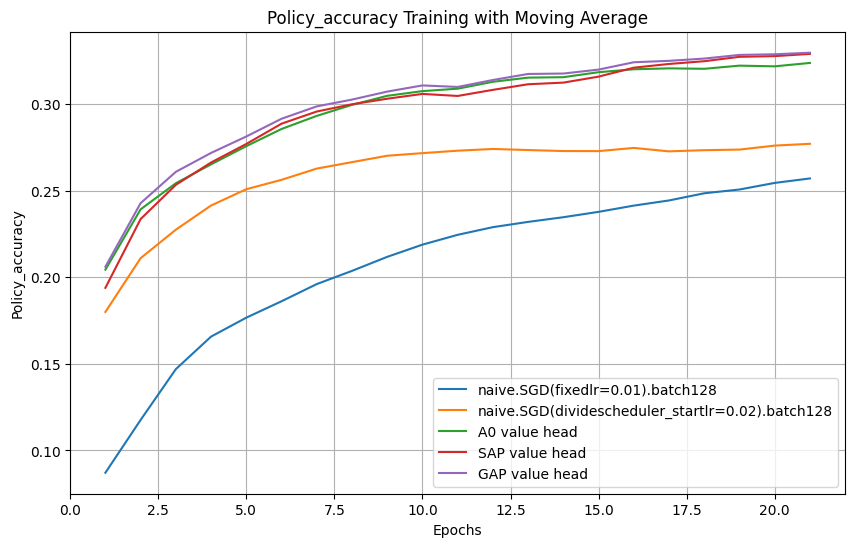

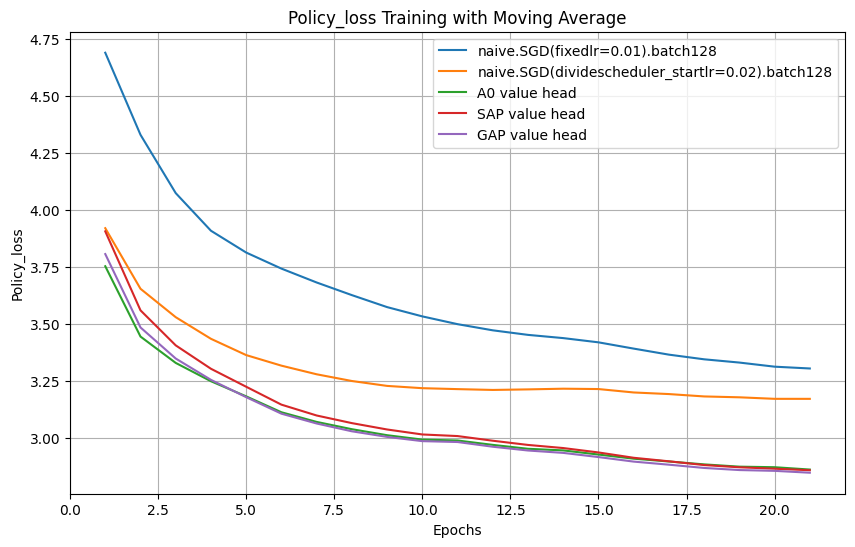

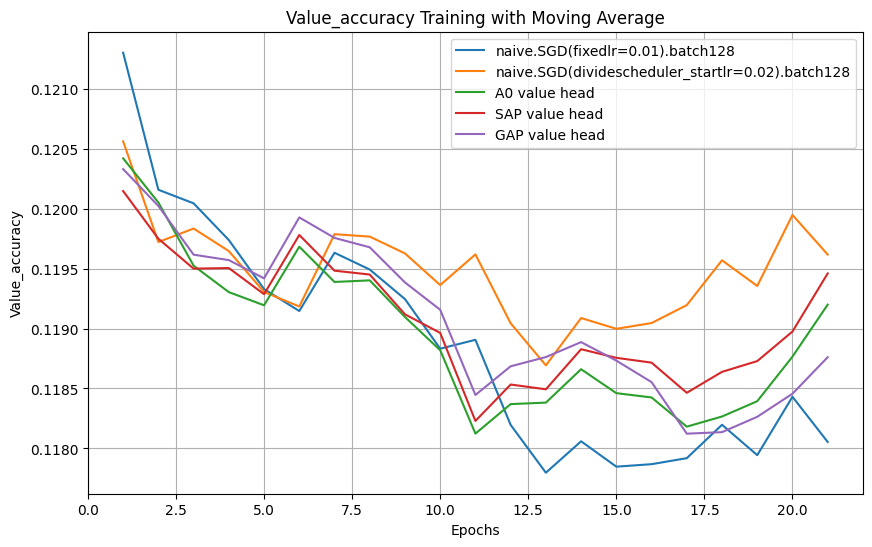

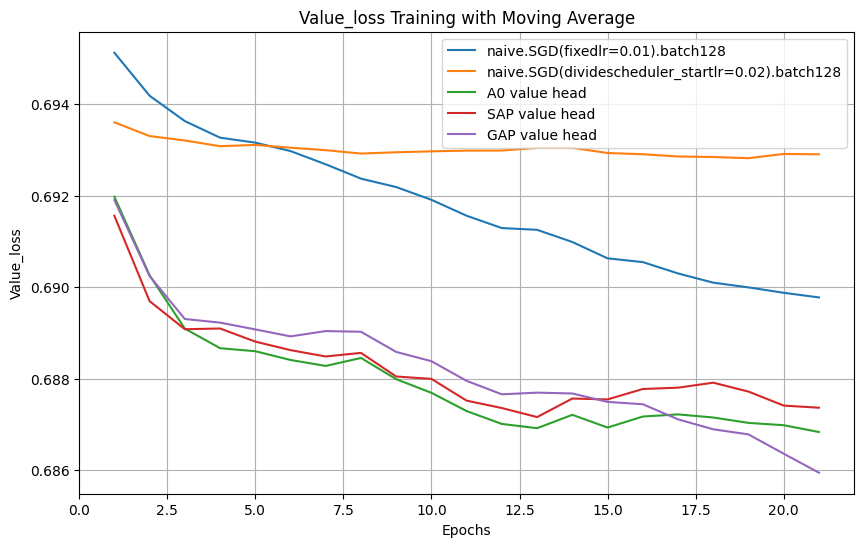

In [38]:
experiments_data = {
    "naive.SGD(fixedlr=0.01).batch128": process_json(mode = "r", file_name = "resnet_model_fixed_lr_training_history"),
    "naive.SGD(dividescheduler_startlr=0.02).batch128": process_json(mode = "r", file_name = "resnet_model_adaptive_lr_batch_128_training_history"),
    "A0 value head": process_json(mode = "r", file_name = "optimal_resnet_alphazero_value_head_batch_32_training_history"),
    "SAP value head": process_json(mode = "r", file_name = "optimal_resnet_SAP_value_head_batch_32_training_history"),
    "GAP value head": process_json(mode = "r", file_name = "optimal_resnet_GAP_value_head_batch_32_training_history")
}
plot_model_training(experiments_data, plot_training=True, plot_validation=False, window_size=5, limit = 25)

## 4.2. Mobilenet


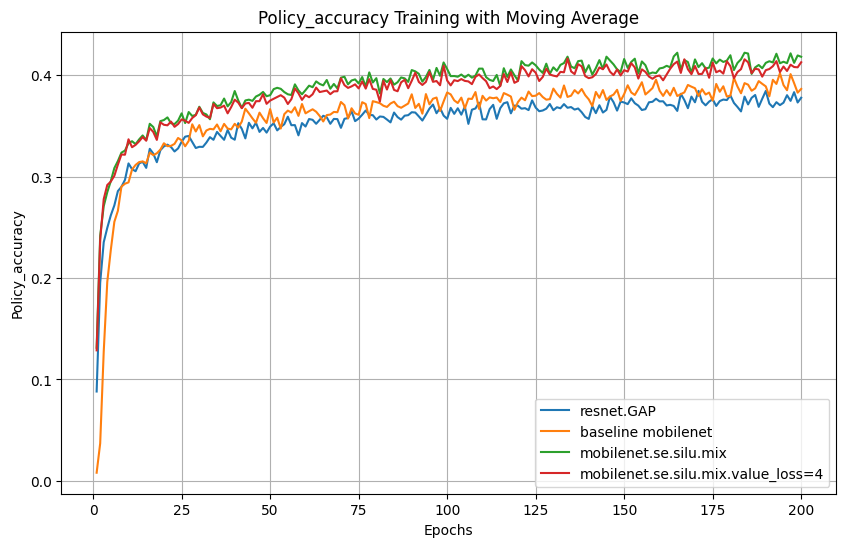

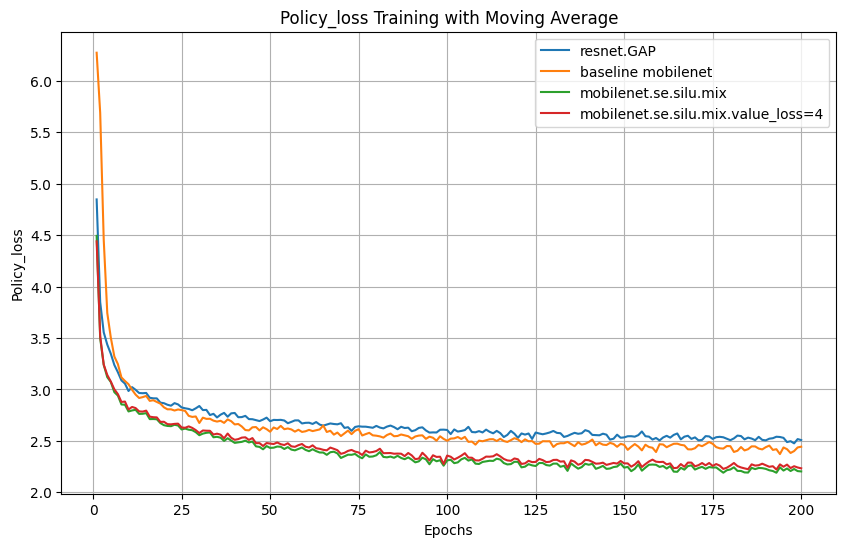

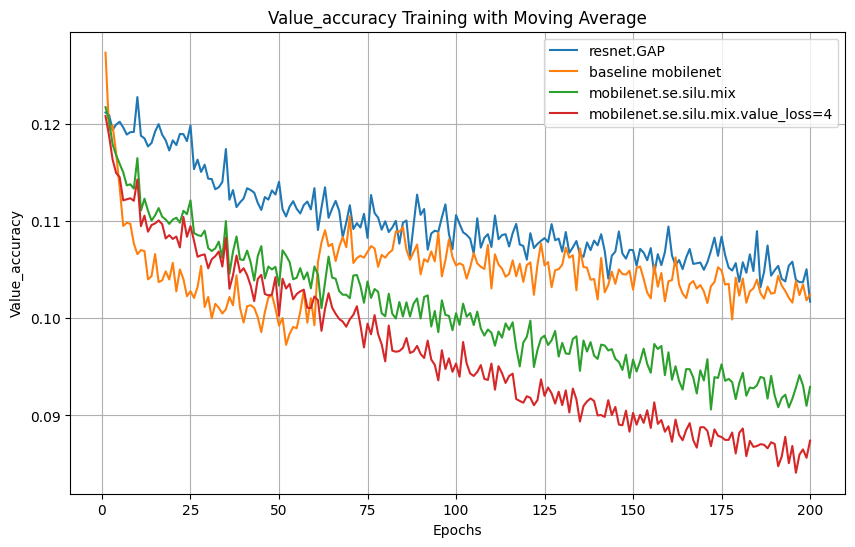

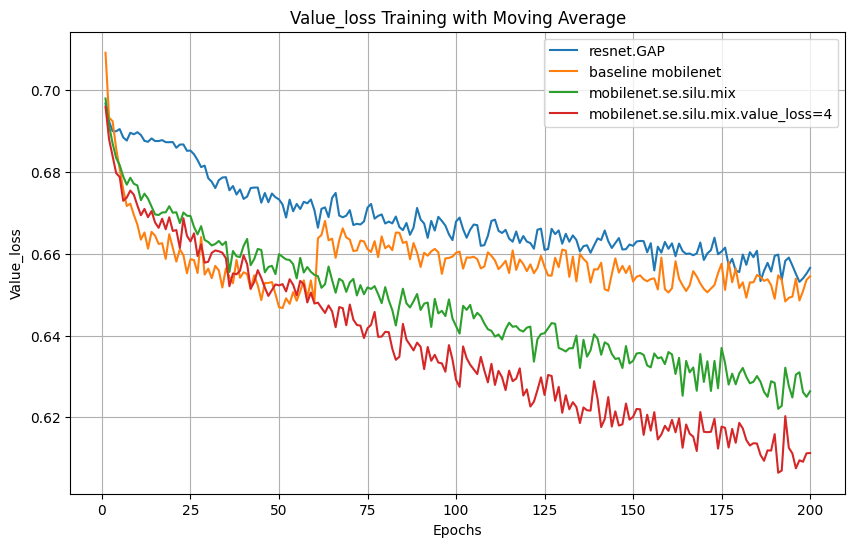

In [52]:
trained_model_data = {
    "resnet.GAP": process_json(mode = "r", file_name = "resnet_GAP_fullytrain_training_history"),

    "baseline mobilenet": process_json(mode = "r", file_name = "mobilenet_fullytrain_training_history"),

    "mobilenet.se.silu.mix": process_json(mode = "r", file_name = "mobilenet_se_adam_silu_mixnet_fullytrain_training_history"),

    "mobilenet.se.silu.mix.value_loss=4": process_json(mode = "r", file_name = "mobilenet_se_adam_silu_mixnet_val4_fullytrain_2_training_history"),
}
plot_model_training(trained_model_data, plot_training=True, plot_validation=False, limit = 200)

## 4.3. Personal experiments

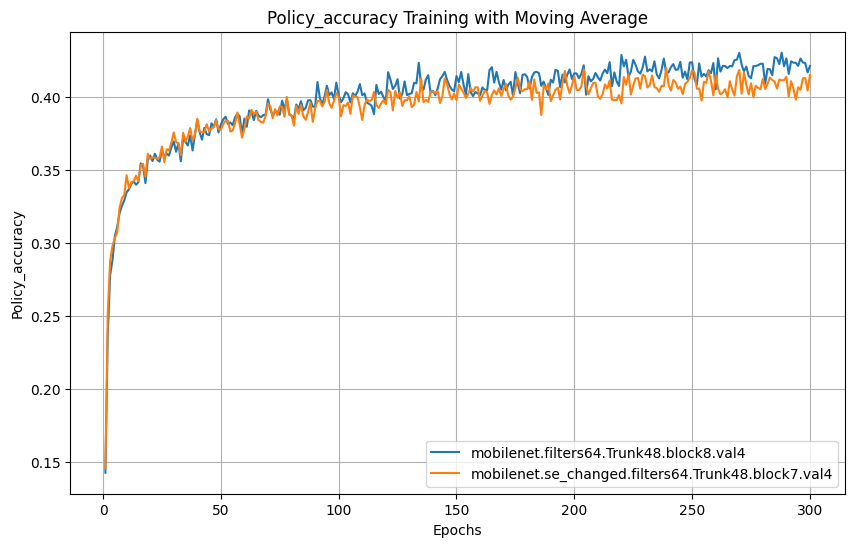

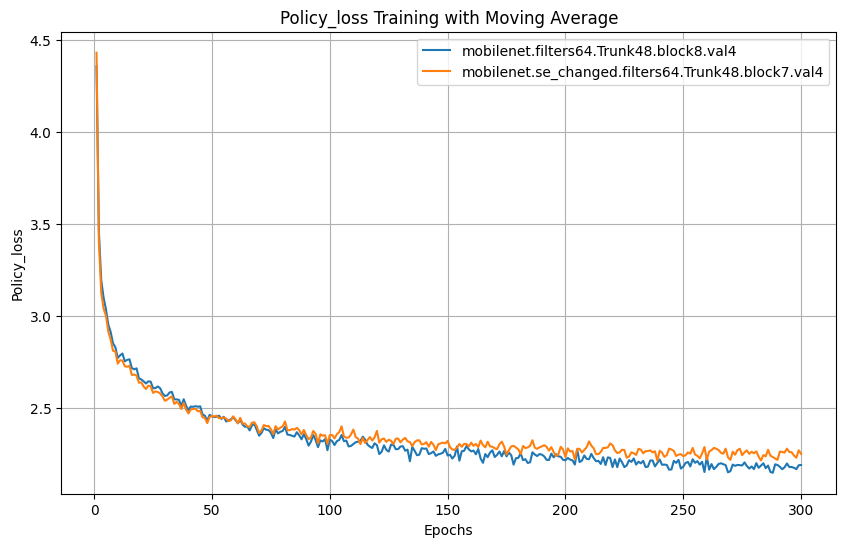

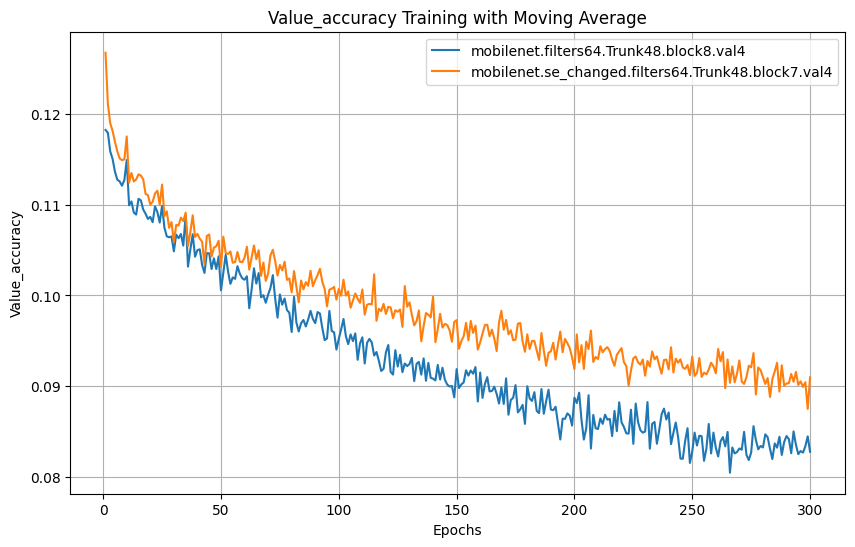

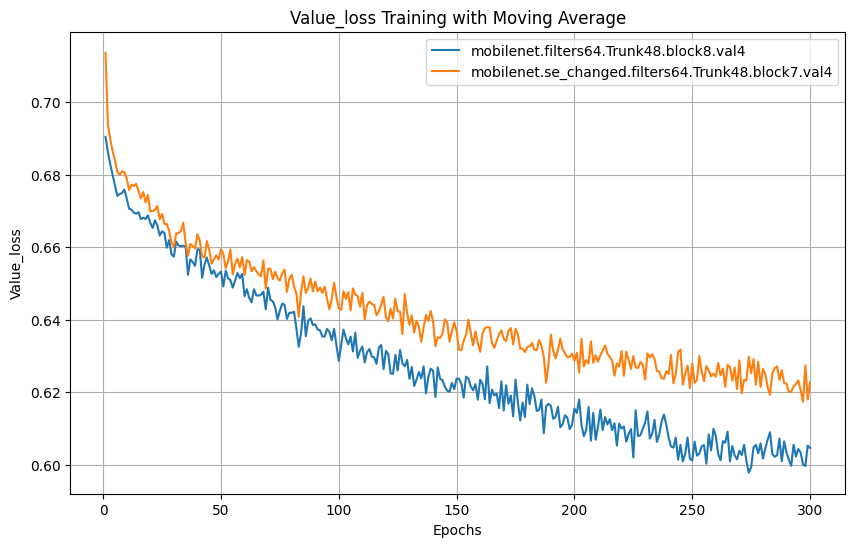

In [57]:
optim_model_data = {
    "mobilenet.filters64.Trunk48.block8.val4": process_json(mode = "r", file_name = "mobilenet_filters64trunk48block8ratio16_vw4_training_history"),
    "mobilenet.se_changed.filters64.Trunk48.block7.val4": process_json(mode = "r", file_name = "mobilenet_se_changed_filters64trunk48block7ratio16_vw2_training_history"),
}
plot_model_training(optim_model_data, plot_training = True, plot_validation=False, limit = 300)

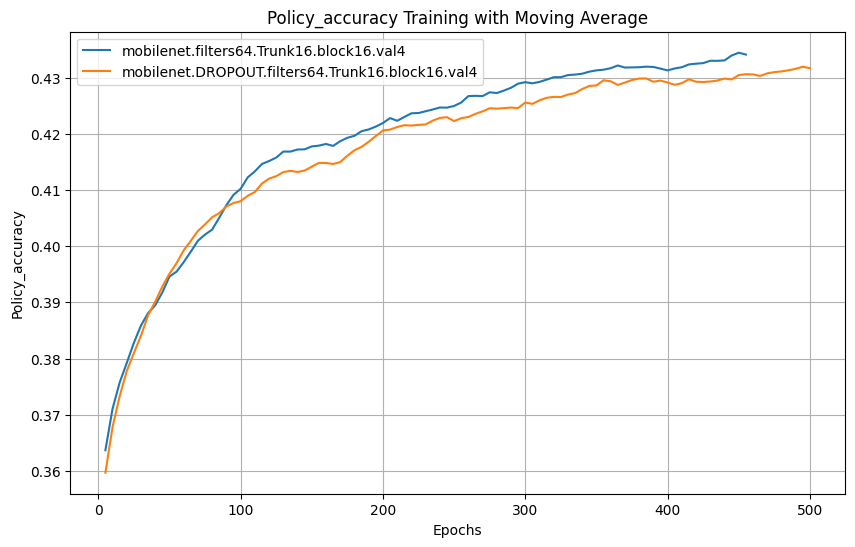

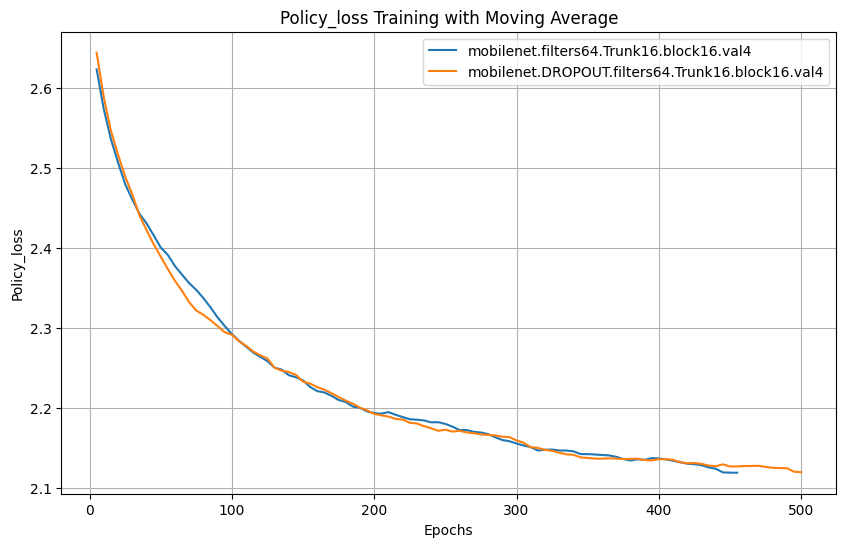

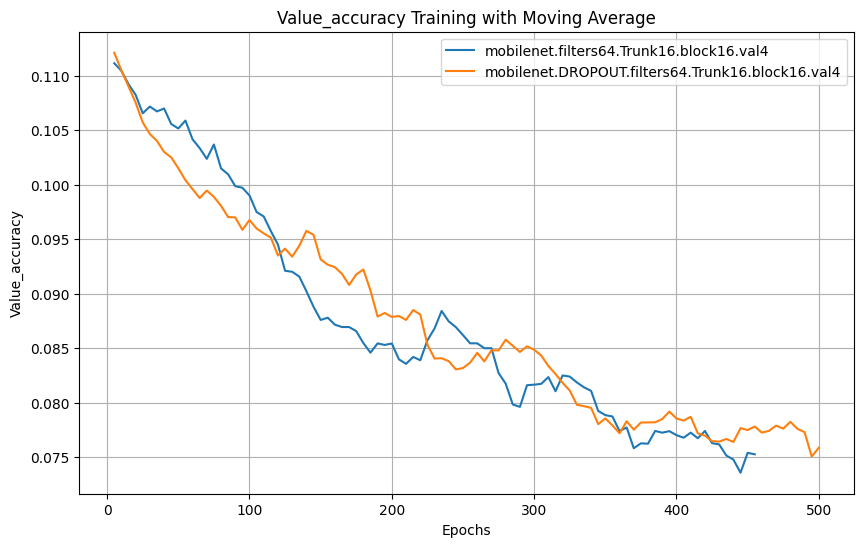

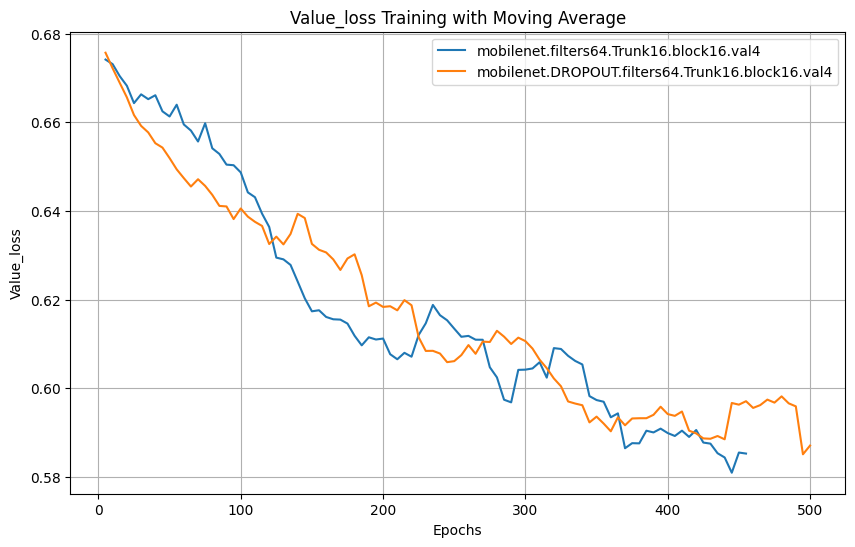

In [79]:
optim_model_data = {
    ########### 500 epochs ###########
    "mobilenet.filters64.Trunk16.block16.val4": process_json(mode = "r", file_name = "mobilenet_FT_filters64trunk16block16ratio16_vw4_training_history"),
    "mobilenet.DROPOUT.filters64.Trunk16.block16.val4": process_json(mode = "r", file_name = "mobilenet_FT_dropout_filters64trunk16block17ratio16_vw4_training_history"),
}
plot_model_training(optim_model_data, plot_training = False, plot_validation=True, window_size =10, limit = 300)

## 4.4. Final models

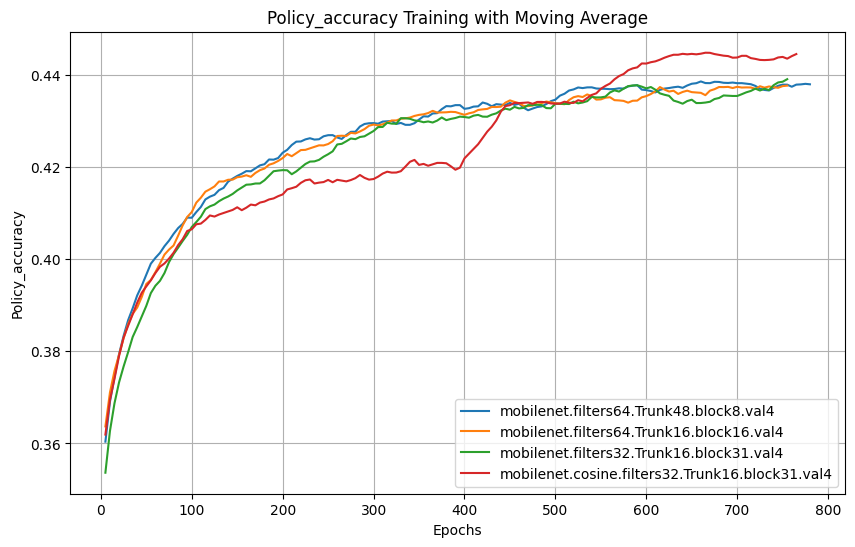

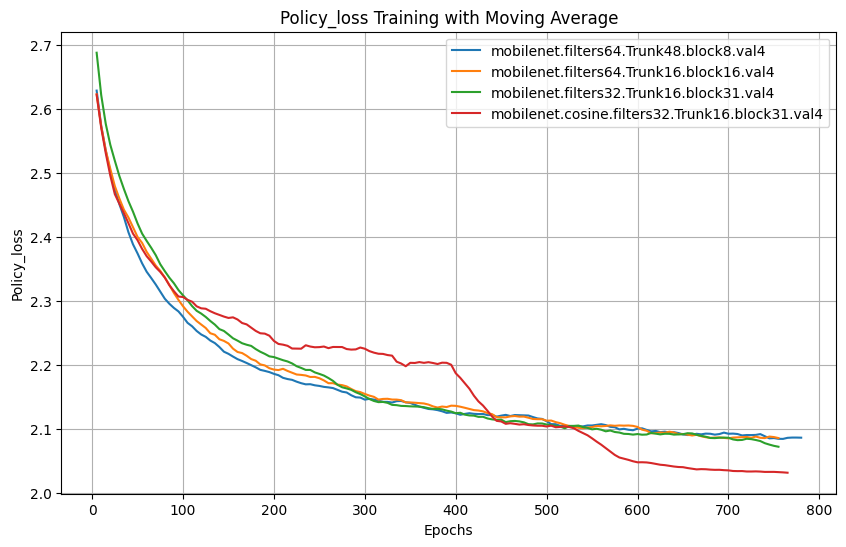

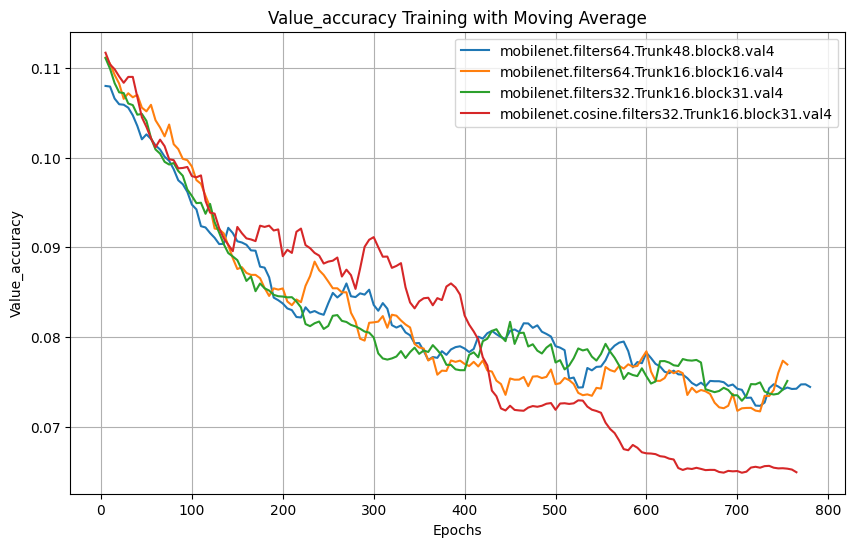

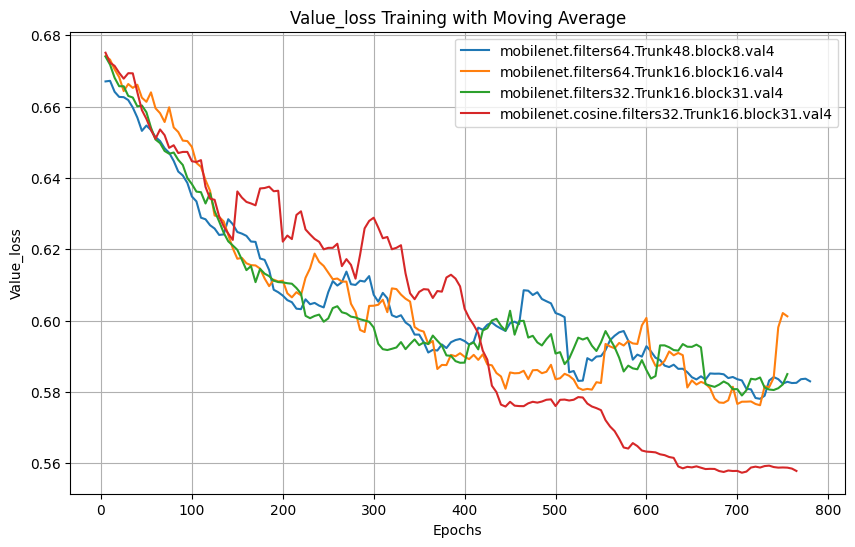

In [78]:
optim_model_data = {
    ########### 800 epochs ###########
    "mobilenet.filters64.Trunk48.block8.val4": process_json(mode = "r", file_name = "mobilenet_FT2_filters64trunk48block8ratio16_vw4_training_history"),
    "mobilenet.filters64.Trunk16.block16.val4": process_json(mode = "r", file_name = "mobilenet_FT2_filters64trunk16block16ratio16_vw4_training_history"),
    "mobilenet.filters32.Trunk16.block31.val4": process_json(mode = "r", file_name = "mobilenet_FT2_filters32trunk16block31ratio16_vw4_training_history"),
    "mobilenet.cosine.filters32.Trunk16.block31.val4": process_json(mode = "r", file_name = "mobilenet_FT3_cosine_filters32trunk16block31ratio16_vw4_training_history"),
}
plot_model_training(optim_model_data, plot_training = False, plot_validation=True, window_size = 10)

# 5.1 Sandbox

## 3.3. EfficientFormer

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers

def meta_block_4d(x, filters):
    # Pooling Layer
    x_pool = layers.AveragePooling2D(pool_size=(2, 2), padding='same')(x)

    # Convolutional Layers with Batch Normalization and GeLU
    x = layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x_pool)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)

    x = layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Residual Connection
    x = layers.Add()([x, x_pool])
    return x

def meta_block_3d(x, num_heads, projection_dim):
    # Linear Layers
    x_linear = layers.Dense(projection_dim, use_bias=False)(x)

    # Self-Attention Mechanism
    q = layers.Dense(projection_dim, use_bias=False)(x_linear)
    k = layers.Dense(projection_dim, use_bias=False)(x_linear)
    v = layers.Dense(projection_dim, use_bias=False)(x_linear)

    # Compute Attention Scores
    attention_scores = tf.matmul(q, k, transpose_b=True)
    attention_scores = tf.nn.softmax(attention_scores / tf.math.sqrt(tf.cast(projection_dim, tf.float32)))

    # Apply Attention Weights
    attention_output = tf.matmul(attention_scores, v)

    # GeLU Activation
    x = layers.Activation('gelu')(attention_output)

    # Residual Connection
    x = layers.Add()([x, x_linear])
    return x

def efficient_former_l1(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Convolutional Stem
    x = layers.Conv2D(48, kernel_size=3, padding='same', activation='relu')(inputs)

    # MetaBlock Layers
    x = meta_block_4d(x, 48)
    x = meta_block_4d(x, 48)
    # x = meta_block_4d(x, 48)
    # x = meta_block_3d(x, num_heads=4, projection_dim=96)
    x = meta_block_3d(x, num_heads=3, projection_dim=96)
    x = meta_block_3d(x, num_heads=3, projection_dim=96)
    x = meta_block_3d(x, num_heads=3, projection_dim=96)

    # Policy Head
    policy_output = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(x)

    # Value Head
    value_output = layers.GlobalAveragePooling2D()(x)
    value_output = layers.Dense(50, activation='relu')(value_output)
    value_output = layers.Dense(1, activation='sigmoid')(value_output)

    model = models.Model(inputs=inputs, outputs=[policy_output, value_output])
    return model

# Example usage
input_shape = (19, 19, 1)  # For a Go board
model = efficient_former_l1(input_shape)
model.summary()


In [ ]:
process_json(mode = "r", file_name = "mobilenet_FT2_filters64trunk16block16ratio16_vw4_training_history")["validation"]["value_accuracy"][-1]

In [ ]:
process_json(mode = "r", file_name = "mobilenet_se_adam_cosine_silu_mixnet_val4_fullytrain_2_training_history")["training"]["policy_accuracy"][-1]

0.42080000042915344

In [ ]:
process_json(mode = "r", file_name = "mobilenet_optimized_se_changed_filters64trunk48block7ratio16_vw4_training_history")["training"]["policy_accuracy"][-1]

0.4253999888896942